In [1]:
from setup import proj_dir, out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

from collections import OrderedDict
import os


import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size":12})
%matplotlib inline
from matplotlib.ticker import NullFormatter
import seaborn as sns
import numpy as np
from time import time

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
# import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms

import glob
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

from dataloader import load_demo
from dataloader import image_loader
from M1_util_train_test import load_model
from util_image import inverse_transform
import util_plot
from setup import *


In [3]:
model_type = 'SAE'
zoomlevel = 'zoom15'
output_dim = 3
model_run_date = "2208"
sampling='stratified'
normalization = 'minmax'
data_version = '1571'
variable_names = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']
model_save_variable_names = ['totpop','pct25-34','pct35-50','pctsenior',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pctcolgrad','avg_tt_to_work','inc']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
demo_cs, demo_np = load_demo(data_dir, norm=normalization)

In [155]:
v1 = 'D'
v2 = 1 
weight, lr, wd = get_hp_from_version_code(v1,v2)

if weight > 100:
    weightt = 1/weight
    weight = 1

else:
    weightt = 1

In [156]:
args = {'weight':weight,
        'weightt':weightt,
        'image_size': 224, 
        'depth': -1,
       'base_channels':64,
       'output_dim':output_dim,
       'num_demo_vars':len(variable_names),
       'demo_norm': normalization,
       'cardinality':1,
       'epochs':200,
       'batch_size':16,
       'base_lr':lr,
       'weight_decay':wd,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[50,100]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':True}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('input_shape', (1, 3, 32, 32)),
    ('output_dim', args['output_dim']),
    ('num_demo_vars', args['num_demo_vars'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('momentum', args['momentum']),
    ('nesterov', args['nesterov']),
    ('milestones', json.loads(args['milestones'])),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size']),
    ('demo_norm', args['demo_norm'])
])

run_config = OrderedDict([
    ('weight', args['weight']),
    ('weightt', args['weightt']),
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

# Load Model

In [157]:
# Check one model exists for this config
model_path = glob.glob(model_dir+"SAE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v1)+"_"+str(v2)+"_"+
                model_run_date+"_*.pt")
#
if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)
    print(model_dir+"SAE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v1)+"_"+str(v2)+"_"+
                model_run_date+"_*.pt")

/dreambig/qingyi/image_chicago/models/SAE_zoom15_18432_D_1_2208_395.pt loaded.


In [158]:
# load model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config['model_config'])

config['model_config']['input_shape'] = [1,2048,config['model_config']['output_dim'],config['model_config']['output_dim']]

config['model_config']['conv_shape'] = [data_config['image_size']//32,data_config['image_size']//32]
config['model_config']['output_channels'] = 3

decoder = load_model(config['model_config']['arch'], 'Decoder', config['model_config'])

config['encoder'] = encoder
config['decoder'] = decoder

model = load_model('autoencoder','Autoencoder', config)
model.load_state_dict(saved['model_state_dict']);
model = model.to(device)
model.eval();

In [125]:
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         data_config['image_size'], data_version=data_version,
                                         sampling=sampling, recalculate_normalize=False)

28278 images in dataset
3142 images in dataset


# Encoder Embeddings

In [159]:
# Check if embeddings have been saved
files = glob.glob(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       v1+"_"+str(v2)+"_"+model_run_date+".pkl")

if len(files) == 1:
    print("Loading Existing Embedding", proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       v1+"_"+str(v2)+"_"+model_run_date+".pkl")
    with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       v1+"_"+str(v2)+"_"+model_run_date+".pkl", "rb") as f: 
        encoder_output = pkl.load(f)
        im = pkl.load(f)
        ct = pkl.load(f)
        
elif len(files) > 1:
    print("Multiple Files exist. Check specified path.")
    
else: # Calculate Embedding
    ct = []
    encoder_output = []
    im = []

    for step, data in enumerate(train_loader):
        data1 = data[1].to(device)
        ct += [s[s.rindex("/")+1: s.rindex("_")]for s in data[0]]
        encoder_output += [encoder(data1).cpu().detach().numpy()]
        im += data[0]
        if step % 10 == 0:
            print(step, end='\t')

    for step, data in enumerate(test_loader):
        data1 = data[1].to(device)
        ct += [s[s.rindex("/")+1: s.rindex("_")]for s in data[0]]
        encoder_output += [encoder(data1).cpu().detach().numpy()]
        im += data[0]
        if step % 10 == 0:
            print(step, end='\t')

    encoder_output = np.vstack(encoder_output)    

#     print(encoder_output.shape)
    encoder_output = encoder_output.reshape(len(encoder_output), -1)

    # Save Embeddings

    with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       v1+"_"+str(v2)+"_"+model_run_date+".pkl", "wb") as f:
        pkl.dump(encoder_output, f)
        pkl.dump(im, f)
        pkl.dump(ct, f)

Loading Existing Embedding /dreambig/qingyi/image_chicago/latent_space/SAE_zoom15_18432_D_1_2208.pkl


# Create perturbed epsilon around existing embeddings
- good quality images can only be obtained from high latent space dimension

In [56]:
n = 20

sample_embedding = encoder_output[:n, :]
embedding_dim = sample_embedding.shape[1]

from torchvision import transforms
for i in range(n): 
    fig, ax = plt.subplots(1,4, figsize=(20,6))
    decoder_in = torch.tensor(sample_embedding[i])
    decoder_in = decoder_in.to(device)
    decoder_in = decoder_in.view(1, -1, output_dim, output_dim)
    reconstruct = decoder(decoder_in)[0]
    reconstruct = inverse_transform(reconstruct.cpu())

    im = transforms.ToPILImage()(reconstruct).convert("RGB")
    ax[0].imshow(im)
    ax[0].axis('off')
    ax[0].set_title("Original")
    
    for e in range(3,0,-1):
        decoder_in = torch.tensor(sample_embedding[i])
        epsilon = torch.normal(0, 10**(-e), size = (output_dim,)).view(-1)
        decoder_in += epsilon

        decoder_in = decoder_in.view(1, -1, output_dim, output_dim)
        decoder_in = decoder_in.to(device)
        reconstruct = decoder(decoder_in)[0]
        reconstruct = inverse_transform(reconstruct.cpu())

        im = transforms.ToPILImage()(reconstruct).convert("RGB")
        ax[4-e].imshow(im)
        ax[4-e].axis('off')
        ax[4-e].set_title(str(10**(3-e))+"%")
    
    fig.savefig(out_dir+"image_samples/latent_perturb/"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+ct[i]+".png")


# Aggregate Embeddings

In [160]:
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Latent Space Visualization with tSNE

In [161]:
# check if tSNE is already done
tsne_file = glob.glob(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+v1+"_"+model_run_date+".csv")


In [162]:
if len(tsne_file) != 0:
    df_ct = pd.read_csv(tsne_file[0])
else:
    from sklearn import manifold
    method = manifold.TSNE(n_components=2, init='pca', random_state=1)
    t0 = time()
    # tsne_im = method.fit_transform(encoder_output)
    tsne_ct = method.fit_transform(aggregate_embeddings)
    t1 = time()
    print("tSNE Running time %s: %d sec" % ('Time', t1 - t0))

    demo_df = pd.read_csv(data_dir+"demo_tract.csv")
    demo_df['pop_density'] = demo_df['tot_population'] / demo_df['area']
    demo_df['COUNTYA'] = demo_df['COUNTYA'].astype('str')

    # tSNE done on individual images
    # df_im = pd.DataFrame(tsne_im, columns = ['x0', 'x1'])
    # df_im['geoid'] = ct
    # df_im = pd.merge(df_im, demo_df, on='geoid')

    # tSNE done on aggregate embeddings
    df_ct = pd.DataFrame(tsne_ct, columns = ['x0', 'x1'])
    df_ct['geoid'] = unique_ct

    df_ct = pd.merge(df_ct, demo_df, on='geoid')

    print(df_ct.columns.tolist())

    df_ct['pop_density'] /= 1000
    df_ct['inc_per_capita'] /= 1000
    df_ct['pct_adult'] = df_ct['pct25_34yrs']+df_ct['pct35_50yrs']
    df_ct['pct_senior'] = df_ct['pctover65yrs']

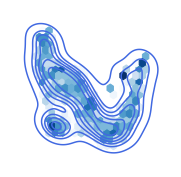

In [163]:
# density plot
fig, ax = plt.subplots(1,1,figsize=(3,3))
hexagons = ax.hexbin(df_ct["x0"].to_numpy(), df_ct["x1"].to_numpy(), gridsize=17, mincnt=1, cmap='Blues')
sns.kdeplot(x=df_ct["x0"].to_numpy(), y=df_ct["x1"].to_numpy(), ax=ax, levels=7, color='royalblue')
ax.axis('off')
fig.savefig(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           v1+"_"+model_run_date+"_density.png", bbox_inches='tight')
plt.show()

In [61]:
a = pd.DataFrame(np.concatenate([hexagons.get_offsets(), hexagons.get_array().reshape(-1,1)], axis=1), columns=['x0','x1','num'])


In [36]:
a = a.sort_values(by='num', ascending=False)

In [37]:
c1 = "17_31_540102"
c2 = "17_43_846413"
c3 = "17_31_221200"
c4 = "17_31_610300"
c5 = "17_197_883305"

In [38]:
df_ct[df_ct['geoid'].isin([c1, c2, c3, c4, c5])]

,x0,x1,geoid,COUNTYA,TRACTA,tot_population,pct25_34yrs,pct35_50yrs,pctover65yrs,pctwhite_alone,...,col_grad,PTcommute,avg_tt_to_work,inc_per_capita,area,INTPTLAT,INTPTLON,pop_density,pct_adult,pct_senior
139,27.312254,-26.654882,17_197_883305,197,883305,3061,0.097027,0.171839,0.112055,0.950670,...,510,33,33.405878,36.022159,7.124570,41.446817,-88.211134,0.429640,0.268866,0.112055
276,-49.966076,29.706810,17_31_221200,31,221200,2917,0.367158,0.244086,0.067535,0.816250,...,1401,810,34.224490,59.686282,0.330185,41.921083,-87.704650,8.834434,0.611244,0.067535
477,-33.189648,-15.812670,17_31_540102,31,540102,3207,0.134705,0.138447,0.071718,0.033365,...,89,343,52.809934,12.307225,5.293149,41.667330,-87.605449,0.605877,0.273152,0.071718
502,-49.108009,11.555132,17_31_610300,31,610300,5941,0.111597,0.173035,0.055715,0.518600,...,319,405,33.578082,12.124585,2.381935,41.816178,-87.675102,2.494191,0.284632,0.055715
1327,-5.937973,-1.696907,17_43_846413,43,846413,3743,0.180069,0.209992,0.223885,0.764360,...,1731,184,33.005675,48.882834,5.440552,41.806214,-88.196099,0.687982,0.390061,0.223885


In [81]:
def plot_hex(var, cmap):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    im = ax.hexbin(df_ct["x0"].to_numpy(), df_ct["x1"].to_numpy(), C=df_ct[var], gridsize=17, cmap=cmap)
    cax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
    fig.colorbar(im, cax=cax)
    ax.axis('off')
    fig.savefig(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           v1+"_"+model_run_date+"_"+var+".png", bbox_inches='tight')
    return fig

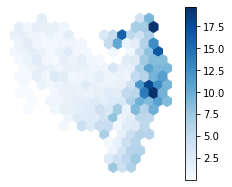

In [82]:
plot_hex('pop_density', 'Blues');
plt.show()

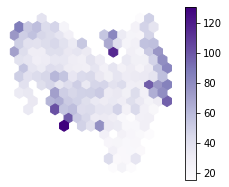

In [83]:
plot_hex('inc_per_capita', 'Purples');
plt.show()

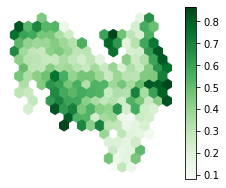

In [84]:
plot_hex('pct_col_grad', 'Greens');
plt.show()

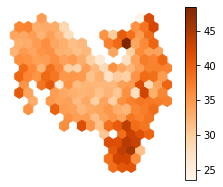

In [85]:
plot_hex('avg_tt_to_work', 'Oranges');
plt.show()

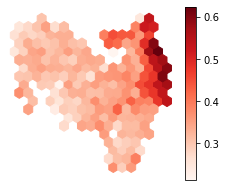

In [86]:
plot_hex('pct_adult', 'Reds');
plt.show()

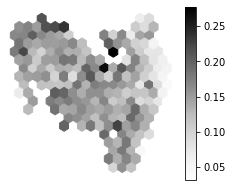

In [87]:
plot_hex('pct_senior', 'Greys');
plt.show()

# Latent Space Clustering

In [120]:
# DBSCAN does not really work
# Getting either one cluster or no cluster

# from scipy.spatial import distance
# d = []
# for i in range(10000):
#     a = np.random.randint(0, 7410)
#     b = np.random.randint(0, 7410)
#     d.append(distance.euclidean(encoder_output[a], encoder_output[b]))
# plt.hist(d)
# plt.show()
# from sklearn.cluster import DBSCAN
# clustering = DBSCAN(eps=25, min_samples=10).fit(aggregate_embeddings)
# pd.Series(clustering.labels_).value_counts()

 0    1531
-1      29
 1      11
dtype: int64

In [149]:
from sklearn.cluster import KMeans

kmeans_ct = KMeans(n_clusters=5)
kmeans_ct.fit(aggregate_embeddings)
df_ct['kmeans'] = kmeans_ct.labels_

pd.Series(kmeans_ct.labels_).value_counts().sort_index()

0    132
1    950
2    176
3    273
4     40
dtype: int64

498 20.020655
598 10.116737
291 13.796076
256 15.629655
385 21.121075


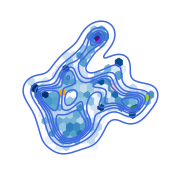

In [154]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
hexagons = ax.hexbin(df_ct["x0"].to_numpy(), df_ct["x1"].to_numpy(), gridsize=17, mincnt=1, cmap='Blues')
sns.kdeplot(x=df_ct["x0"].to_numpy(), y=df_ct["x1"].to_numpy(), ax=ax, levels=7, color='royalblue')

colors = ['forestgreen','orange','purple','pink','yellowgreen','black']
i = 0
for c in kmeans_ct.cluster_centers_:
    idx = np.argmin(sklearn.metrics.pairwise_distances(aggregate_embeddings, c.reshape(1,-1)))
    print(idx+2, np.min(sklearn.metrics.pairwise_distances(aggregate_embeddings, c.reshape(1,-1))))
    ax.scatter(df_ct.iloc[idx]["x0"], df_ct.iloc[idx]["x1"], c=colors[i],s=30)
    i += 1

plt.axis("off")
plt.show()

# fig.savefig(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
#                     model_run_date+"_traj.png", bbox_inches='tight')
    

In [66]:
df_ct.iloc[idx]["x1"]

4.8935494

In [102]:
print(sklearn.metrics.pairwise_distances(kmeans_ct.cluster_centers_))

[[ 0.       58.746113 85.59417  20.204338 67.95889  41.57516 ]
 [58.746113  0.       37.693924 42.600872 24.190315 22.611992]
 [85.59417  37.693924  0.       70.814316 27.89336  50.636578]
 [20.204338 42.600872 70.814316  0.       51.368767 22.982935]
 [67.95889  24.190315 27.89336  51.368767  0.       30.189686]
 [41.57516  22.611992 50.636578 22.982935 30.189686  0.      ]]


In [14]:
# kmeans_im = KMeans(n_clusters=5)
# kmeans_im.fit(encoder_output)
# df_im['kmeans'] = kmeans_im.labels_
# pd.Series(kmeans_im.labels_).value_counts()


In [4]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
 

ModuleNotFoundError: No module named 'geoplot'

In [5]:
from cartopy.mpl.geoaxes import GeoAxesSubplot

ModuleNotFoundError: No module named 'cartopy'

In [6]:
from pyproj import CRS

In [7]:
CRS.from_epsg(26915)

<Derived Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [23]:
shp = gpd.read_file(data_dir+"tl_2018_17_tract/tl_2018_17_tract.shp")

shp['geoid'] = shp['STATEFP'].astype(str)+'_'+shp['COUNTYFP'].str.lstrip('0')+'_'+shp['TRACTCE'].str.lstrip('0')
# shp['geometry'] = shp['geometry'].to_crs('epsg:26916')

f = pd.read_csv(data_dir+"census_tracts_filtered-"+data_version+".csv")

shp_f = pd.merge(shp, f, on='geoid')

shp_ct = pd.merge(shp, df_ct, on='geoid')

In [ ]:
gplt.choropleth(shp_ct, hue='kmeans', edgecolor='None', projection=gcrs.AlbersEqualArea(), cmap='Accent')
plt.savefig(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           model_run_date+"_kmeans_all.png", bbox_inches='tight')
plt.show()

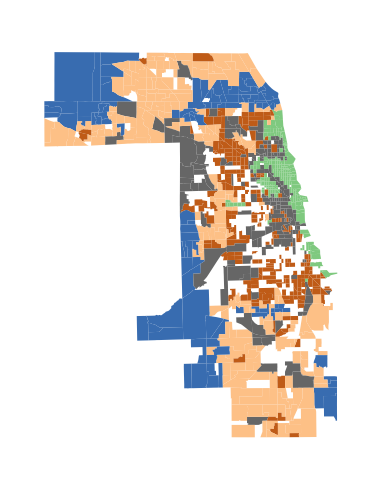

In [154]:
gplt.choropleth(shp_ct[shp_ct['COUNTYFP']=='031'], hue='kmeans', edgecolor='None', projection=gcrs.AlbersEqualArea(), cmap='Accent')
plt.savefig(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           model_run_date+"_kmeans_cook.png", bbox_inches='tight')
plt.show()

In [153]:
df_ct[['geoid','COUNTYA','TRACTA', 'x0','x1','kmeans']].to_csv(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           v1+"_"+model_run_date+".csv", index=False)


In [104]:
shp_f['train_test'] = 1-shp_f['train_test']

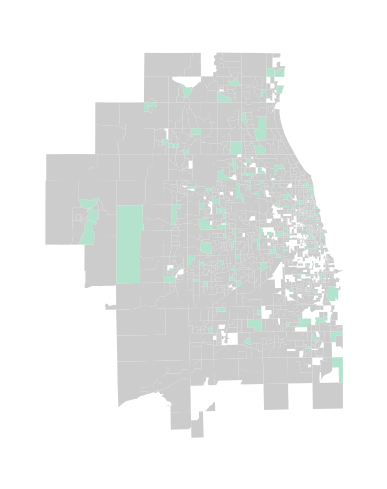

In [105]:
gplt.choropleth(shp_f, hue='train_test', projection=gcrs.AlbersEqualArea(),cmap='Pastel2')
plt.show()

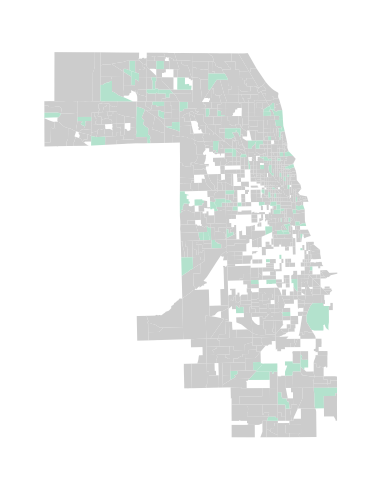

In [106]:
gplt.choropleth(shp_f[shp_f['COUNTYFP']=='031'], hue='train_test', projection=gcrs.AlbersEqualArea(),cmap='Pastel2')
plt.show()